# Parameter Tuning

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from tqdm import tqdm
import pickle

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


%matplotlib inline

In [72]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [134]:
df = pd.read_csv('clean_data_train.csv')
df['idx'] = range(df.shape[0])

In [136]:
df_X = df.iloc[:,12:].copy()
df_y = df.iloc[:,:12].copy()

In [137]:
test_size = 0.3
seed = 7
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=test_size,
random_state=seed)

df_X_train_train, df_X_train_validate, df_y_train_train, df_y_train_validate =\
train_test_split(df_X_train, df_y_train, test_size=test_size,
random_state=seed)

In [138]:
def multi_month_2_one(df_X, df_y):
    y_con = []
    X_con = []
    #df_vari = df.iloc[:, 12:].copy()
    for col in df_y.columns:
        bools = ~df_y[col].isnull()
        df_buf = df_X.loc[bools,:].copy()
        df_buf['month'] = int(col.split('M')[1])
        # one_hot_encode ''month''
        for i in range(1,13):
            df_buf['month_'+str(i)] = (df_buf['month']==i).astype(int)
        del df_buf['month']
    
        X_con.append(df_buf)
        y_con.extend(list(np.log1p(df_y.loc[bools,col].values)))
    X = pd.concat(X_con)
    y = np.array(y_con)
    return X, y

X_train_validate, y_train_validate = multi_month_2_one(df_X_train_validate, df_y_train_validate)
X_train_train, y_train_train = multi_month_2_one(df_X_train_train, df_y_train_train)
X_test, y_test = multi_month_2_one(df_X_test, df_y_test)
X_train, y_train = multi_month_2_one(df_X_train, df_y_train)

### Random Forest Benchmark

In [98]:
# random forest benchmark
rfr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=8000, n_jobs=6)
rfr.fit(X_train.values, y_train)

0.68436408204349841

In [115]:
y_pred = rfr.predict(X_test.values)
rf_error = np.sqrt(np.sum((y_test - y_pred)**2)/len(y_pred))
print('RMSLE of Random Forest Regressor is: ', rf_error)

RMSLE of Random Forest Regressor is:  0.684364082043


## Tuning XGBoost
### Step 1: Find the number of trees for a large learning rate (0.1)

In [139]:
# find the rough number of trees
eval_set = [(X_train_validate, y_train_validate)]
model = XGBRegressor(learning_rate=0.1, subsample=0.7, colsample_bytree=0.7, max_depth=10, n_estimators=10000)
model.fit(X_train_train, y_train_train,eval_metric="rmse", early_stopping_rounds=100, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:6.36956
Will train until validation_0-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:5.75536
[2]	validation_0-rmse:5.20146
[3]	validation_0-rmse:4.7023
[4]	validation_0-rmse:4.25484
[5]	validation_0-rmse:3.85241
[6]	validation_0-rmse:3.49284
[7]	validation_0-rmse:3.17179
[8]	validation_0-rmse:2.87716
[9]	validation_0-rmse:2.61544
[10]	validation_0-rmse:2.38455
[11]	validation_0-rmse:2.17482
[12]	validation_0-rmse:1.9904
[13]	validation_0-rmse:1.82519
[14]	validation_0-rmse:1.67964
[15]	validation_0-rmse:1.54755
[16]	validation_0-rmse:1.43093
[17]	validation_0-rmse:1.32913
[18]	validation_0-rmse:1.24019
[19]	validation_0-rmse:1.15823
[20]	validation_0-rmse:1.08532
[21]	validation_0-rmse:1.02386
[22]	validation_0-rmse:0.97124
[23]	validation_0-rmse:0.922069
[24]	validation_0-rmse:0.880566
[25]	validation_0-rmse:0.846042
[26]	validation_0-rmse:0.81735
[27]	validation_0-rmse:0.792127
[28]	validation_0-rmse:0.771659
[29]	validation_0-rmse:0.753874
[30]	valid

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.7)

### Step 2: Grid search to find "max_depth", "subsample", and "colsample_bytree"

In [140]:
# grid search on "max_depth"
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

max_depth = range(4, 14, 1)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
model = XGBRegressor(learning_rate=0.1, subsample=0.7, colsample_bytree=0.7, n_estimators=223)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\A138262\AppData\Local\Continuum\Anaconda3\envs\aind\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best: -0.283657 using {'max_depth': 10}


In [141]:
# grid search on "subsample"
subsample = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_grid = dict(subsample=subsample)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
model = XGBRegressor(learning_rate=0.1, max_depth=10, colsample_bytree=0.7, n_estimators=223)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\A138262\AppData\Local\Continuum\Anaconda3\envs\aind\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best: -0.278075 using {'subsample': 0.9}


In [142]:
colsample_bytree = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_grid = dict(colsample_bytree=colsample_bytree)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
model = XGBRegressor(learning_rate=0.1, max_depth=10, subsample=0.9, n_estimators=223)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\A138262\AppData\Local\Continuum\Anaconda3\envs\aind\lib\site-packages\sklearn\model_selection\_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best: -0.278075 using {'colsample_bytree': 0.7}


### Step 3: Find the number of trees with small learning rate (0.01)

In [143]:
# find the rough number of trees
eval_set = [(X_train_validate, y_train_validate)]
model = XGBRegressor(learning_rate=0.01, subsample=0.9, colsample_bytree=0.7, max_depth=10, n_estimators=10000)
model.fit(X_train_train, y_train_train,eval_metric="rmse", early_stopping_rounds=1000, eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:6.9858
Will train until validation_0-rmse hasn't improved in 1000 rounds.
[1]	validation_0-rmse:6.9182
[2]	validation_0-rmse:6.85106
[3]	validation_0-rmse:6.78447
[4]	validation_0-rmse:6.71861
[5]	validation_0-rmse:6.65297
[6]	validation_0-rmse:6.58853
[7]	validation_0-rmse:6.52452
[8]	validation_0-rmse:6.46174
[9]	validation_0-rmse:6.39909
[10]	validation_0-rmse:6.33719
[11]	validation_0-rmse:6.27599
[12]	validation_0-rmse:6.2152
[13]	validation_0-rmse:6.15527
[14]	validation_0-rmse:6.0955
[15]	validation_0-rmse:6.03646
[16]	validation_0-rmse:5.97823
[17]	validation_0-rmse:5.92064
[18]	validation_0-rmse:5.86378
[19]	validation_0-rmse:5.80721
[20]	validation_0-rmse:5.75118
[21]	validation_0-rmse:5.69578
[22]	validation_0-rmse:5.64112
[23]	validation_0-rmse:5.58702
[24]	validation_0-rmse:5.53369
[25]	validation_0-rmse:5.48034
[26]	validation_0-rmse:5.42756
[27]	validation_0-rmse:5.37588
[28]	validation_0-rmse:5.32443
[29]	validation_0-rmse:5.27412
[30]	validation_0

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=10000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

### step 4: Retain model with optimal hyper-parameters

In [144]:
model = XGBRegressor(learning_rate=0.01, subsample=0.9, colsample_bytree=0.7, max_depth=10, n_estimators=3718)
model.fit(X_train, y_train,eval_metric="rmse")

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=None, n_estimators=3718, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.9)

In [ ]:
y_pred = model.predict(X_test)
xgb_error = np.sqrt(np.sum((y_test - y_pred)**2)/len(y_pred))
print('RMSLE of XGBoost Regressor is: ', xgb_error)

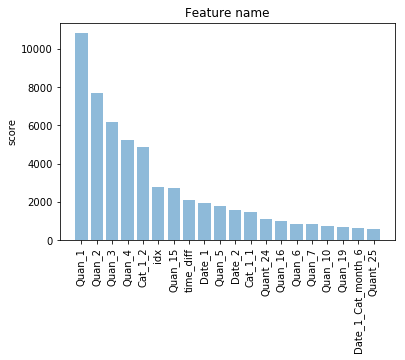

In [114]:
# find the top 20 important features
imp_dict = model.booster().get_fscore()
imp_tups = sorted([(-val, ki) for ki, val in imp_dict.items()])

i = 0
feature_names = []
imp_vals = []

for (val, ki) in imp_tups:
    if i==20:
        break
    if ki.startswith('month'):
        continue
    feature_names.append(ki)
    imp_vals.append(-val)
    i+=1
    
plt.bar(range(20), imp_vals, align='center', alpha=0.5)
plt.xticks(range(20), feature_names, rotation='vertical')
plt.ylabel('score')
plt.title('Feature name')
 
plt.show()

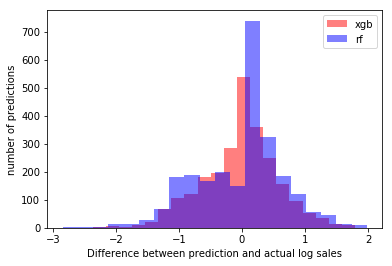

In [130]:
y_pred = model.predict(X_test)
plt.hist(y_pred- y_test, bins=20, color='red', alpha=0.5, label='xgb')
y_pred = rfr.predict(X_test.values)
plt.hist(y_pred- y_test, bins=20, color='blue', alpha=0.5, label='rf')
plt.legend()
plt.xlabel('Difference between prediction and actual log sales')
plt.ylabel('number of predictions')
plt.show()